In [2]:
import pandas as pd
import numpy as np
import vaex

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp

In [3]:
#function for removing collinear tables by threshold
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        print('processed: ' + X[cols[variables]].columns[maxloc])
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [4]:
train_df = vaex.from_csv('final_dataset_new.csv', convert=True, chunk_size=5_000_000)
#train_df = pd.read_csv("final_dataset_new.csv", header=0)

#lets sample out of the dataset so we can train quickly
#train_df = train_df.sample(frac=0.05, random_state=786)

#impute nans
train_df = train_df.fillna(0)

In [4]:
train_df.shape

(2999, 8090)

In [39]:
#aggregate labels
target_category_to_set = 'OTHER'
genres_to_aggregate = []

#lets get genre counts
genre_count = train_df.groupby(by='genre').agg({'genre':'count'})

In [40]:
genre_count = genre_count.to_pandas_df()
genre_count = genre_count.set_index('genre')
genre_count

,count
genre,
Hip-Hop,2265
Pop,3516
Experimental Pop,1138
Loud-Rock,251
Avant-Garde,5252
...,...
Nerdcore,1
Latin,5
Jungle,11


In [44]:
#aggregate sparse genres for list
for index, row in genre_count.iterrows():
    value = row['count']
    #if value <= percent_to_aggregate_to_other * total_rows:
    if value <= 10: 
        genres_to_aggregate.append(index)

In [ ]:
#iterate all rows, and all aggregation genres, and set to new category
#when needed
for index, row in train_df.iterrows():
    for genre in genres_to_aggregate:
        if row['genre'] == genre:
            train_df.loc[index, 'genre'] = target_category_to_set

In [ ]:
labels = train_df["genre"].values
train_df.drop(["genre"], inplace=True, axis=1)

In [ ]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
#vif["features"] = train_df.columns
X=train_df
vif = pd.DataFrame()
drop = pd.DataFrame()
keep = pd.DataFrame()

for i in range(X.shape[1]):
    vif_amount = variance_inflation_factor(X.values, i)
    vif["VIF Factor"] = vif_amount
    vif_column = X.columns[i]
    vif["features"] = vif_column

    if vif_amount > 10:
        drop["VIF Factor"] = vif_amount
        drop["features"] = vif_column
        print('drop: ' + vif_column + ' with VIF = ' + str(vif_amount))
    else:
        keep["VIF Factor"] = vif_amount
        keep["features"] = vif_column  
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print("Keep These Columns")
    print("**************************************")
    keep.round(1)

drop: lowlevel_barkbands_flatness_db_mean with VIF = 13.411376529605432
drop: lowlevel_barkbands_flatness_db_median with VIF = 11.956102304541915
drop: lowlevel_barkbands_kurtosis_dmean with VIF = 254.0352366226337
drop: lowlevel_barkbands_kurtosis_dmean2 with VIF = 66.33634735280998
drop: lowlevel_barkbands_kurtosis_dvar with VIF = 43076.78513423729
drop: lowlevel_barkbands_kurtosis_dvar2 with VIF = 11990.343903102275
drop: lowlevel_barkbands_kurtosis_max with VIF = 89.48837763138212
drop: lowlevel_barkbands_kurtosis_mean with VIF = 1498.8811023678047
drop: lowlevel_barkbands_kurtosis_median with VIF = 720.1425141450057
drop: lowlevel_barkbands_kurtosis_stdev with VIF = 215.20959787463806
drop: lowlevel_barkbands_kurtosis_var with VIF = 4890.855132420988
drop: lowlevel_barkbands_skewness_dmean with VIF = 16.76645612850121
drop: lowlevel_barkbands_skewness_dmean2 with VIF = 18.09548518724244
drop: lowlevel_barkbands_skewness_dvar with VIF = 172.16685735404315
drop: lowlevel_barkbands_s

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [11]:
def calculate_vif2(X, thresh=10):
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    drop = pd.DataFrame()
    keep = pd.DataFrame()

    for i in range(X.shape[1]):
        vif_amount = variance_inflation_factor(X.values, i)
        vif["VIF Factor"] = vif_amount
        vif_column = X.columns[i]
        vif["features"] = vif_column

        if vif_amount > thresh:
            drop["VIF Factor"] = vif_amount
            drop["features"] = vif_column
            print('drop: ' + vif_column + ' with VIF = ' + str(vif_amount))
        else:
            keep["VIF Factor"] = vif_amount
            keep["features"] = vif_column   
    return vif

In [ ]:
#remove multicollinearity

#find the number of CPUs and set the pool
#reduce total core count by 2 to prevent saturation
cores = mp.cpu_count()
pool = Pool(cores)

#create new dataframe, split it by core, create a process to run VIF
train_df_split = pd.DataFrame(train_df) 
train_df_split = np.array_split(train_df, cores, axis=0)
vif = np.vstack(pool.map(calculate_vif2, train_df_split))

In [7]:
#make sure to use stratification
#to balance class representations
X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size=0.25, 
                                                    random_state=42, stratify=labels)

#seperate out scale operations to avoid data leakage
scaler = StandardScaler()
music_scaled_X_train = scaler.fit_transform(X_train)
music_scaled_X_test = scaler.fit_transform(X_test)

PCs = 1491
Cumulative Variance = 0.9906386337179818


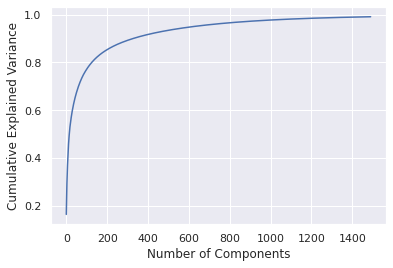

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(music_scaled, labels, test_size=0.25, random_state=42)

#initialize search values for optimal k
i = 1490
variance_explained = 0
target_variance_percentile = 0.99

#find the optimal k
while variance_explained <= target_variance_percentile:
    i=i+1
    pca = PCA(n_components=i)
    forest = RandomForestClassifier(n_estimators=100)
    pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])
    pipe.fit(music_scaled_X_train, y_train)
    pca_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    
    array_length = len(pca_variance_explained)
    variance_explained = pca_variance_explained[array_length - 1]
    
    if variance_explained > target_variance_percentile-0.19:
        print('PCs = '+ str(i))
        print('Cumulative Variance = '+ str(variance_explained))
        
    
#final PCA model
pca = PCA(n_components=i)
forest = RandomForestClassifier(n_estimators=100)
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])
pipe.fit(music_scaled_X_train, y_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [9]:
test_predictions = pipe.predict(music_scaled_X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

Accuracy with RandomForest: 26.655552%


In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold

param_dict = {"pca__n_components":[1491],
              "forest__n_estimators":[100]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

estimator = GridSearchCV(pipe,
                         param_dict,
                         cv=cv,
                         verbose=2)

estimator.fit(music_scaled_X_train, y_train)

Fitting 25 folds for each of 1 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=25.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.1min remaining:    0.0s


[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=30.4min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=42.7min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=27.7min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=37.4min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=25.0min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=37.2min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=31.1min
[CV] f

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 791.5min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=1491,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('forest',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gin...
                                                               min_samples_leaf=1,
    

In [12]:
print("The best parameters: {0}".format(estimator.best_params_))

The best parameters: {'forest__n_estimators': 100, 'pca__n_components': 1491}


In [13]:
test_predictions = pipe.predict(music_scaled_X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

Accuracy with RandomForest: 26.655552%


In [14]:
pipe.set_params(**estimator.best_params_);
pipe.fit(music_scaled_X_train, y_train);

test_predictions = pipe.predict(music_scaled_X_train)
precision = accuracy_score(test_predictions, y_train) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

#test_df = pd.read_csv("../input/sign_mnist_test.csv", header=0)
#test_labels = test_df["genre"].values
#test_df.drop(["genre"], inplace=True, axis=1)

Accuracy with RandomForest: 100.000000%


In [15]:
#create a PCA based training frame
pca = PCA(n_components=i)
new_dataframe_pipe = Pipeline(steps=[('pca', pca)])

principle_components = new_dataframe_pipe.fit_transform(music_scaled_X_train)

In [16]:
music_scaled_X_train_pca = pd.DataFrame(data = principle_components)
music_scaled_y_train = pd.DataFrame(data = y_train, columns = ['genre'])
music_scaled_X_train_pca = pd.concat([music_scaled_X_train_pca, music_scaled_y_train], axis=1)
music_scaled_X_train_pca

,0,1,2,3,4,5,6,7,8,9,...,1482,1483,1484,1485,1486,1487,1488,1489,1490,genre
0,-8.229566,-1.902976,3.037285,18.022181,21.257472,1.006087,0.183701,-2.782119,1.668758,1.340693,...,0.228574,0.010443,-0.001056,0.419442,-0.184098,-0.072992,0.123720,-0.102825,-0.326741,Dance
1,8.708711,-29.185892,22.037479,-9.259812,-8.090364,-3.166292,3.816111,-3.119004,14.542073,-4.394920,...,0.453821,0.308777,0.059496,0.552813,-0.621987,0.025122,-0.241435,0.073065,0.038185,Blues
2,-13.752665,19.815111,-20.657853,21.031589,-16.931611,7.285425,-4.522447,-1.378319,4.427535,-0.859046,...,0.280570,-0.103462,0.084399,-0.322019,-0.417513,0.784926,-0.529272,-0.652729,-0.321636,Lo-Fi
3,-9.348096,4.031171,0.986149,-14.371868,2.033340,-0.350750,-2.541646,13.540084,-1.586789,-2.249359,...,-0.193042,0.518493,-0.597468,-0.144503,-0.056426,0.191189,0.403946,-0.380171,-0.057189,Noise
4,-12.108964,12.803063,-11.596527,13.932410,-6.100534,-13.652660,-1.072243,-9.988401,-13.017333,4.815079,...,0.097341,0.150458,-0.057403,-0.222646,-0.524074,0.217973,-0.143639,-0.274314,0.019272,Noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44977,-9.777618,2.642785,5.614356,-30.916124,4.020509,-2.649198,2.593310,4.168512,-6.490480,0.873398,...,-0.175597,-0.313006,0.687264,-0.471401,-0.269720,-0.454850,0.160136,-0.196080,0.700888,Sound Effects
44978,-13.280689,18.285602,-15.121585,-10.902819,-22.151387,20.688480,-1.606905,1.863389,13.749705,-7.407014,...,-0.133297,-0.473519,0.104891,-0.035579,-0.088967,-0.254515,0.261747,0.003016,0.063559,Pop
44979,-11.713129,9.575915,-4.004367,-13.279178,0.218279,-5.343600,-1.719235,5.906451,-14.362502,2.131165,...,-0.408691,0.278011,-0.022812,-0.302458,0.209981,0.346577,0.381633,0.191565,-0.152279,Avant-Garde
44980,4.021504,-21.107037,13.970044,6.639637,-8.075200,-5.578126,1.501612,-6.407242,14.549367,-3.653486,...,0.121070,-0.031390,-0.281367,0.064026,0.046392,0.800515,0.121373,-0.219115,1.124192,Experimental


In [17]:
#create a PCA based test frame
pca = PCA(n_components=i)
new_dataframe_pipe = Pipeline(steps=[('pca', pca)])

principle_components = new_dataframe_pipe.fit_transform(music_scaled_X_test)

In [18]:
music_scaled_X_test_pca = pd.DataFrame(data = principle_components)
music_scaled_y_test = pd.DataFrame(data = y_test, columns = ['genre'])
music_scaled_X_test_pca = pd.concat([music_scaled_X_test_pca, music_scaled_y_test], axis=1)
music_scaled_X_test_pca

,0,1,2,3,4,5,6,7,8,9,...,1482,1483,1484,1485,1486,1487,1488,1489,1490,genre
0,-9.970117,6.818098,-7.727968,0.095977,9.599847,-5.789358,3.666374,13.480109,-3.578910,1.325185,...,0.001233,0.198882,0.387862,-0.026338,-0.028133,-0.123839,-0.151713,0.094398,-0.015197,Avant-Garde
1,2.741736,-14.142398,15.763048,-10.905533,4.526840,-8.195744,-4.857452,-7.094710,11.574013,-3.303492,...,0.174258,-0.379888,0.336483,0.081884,-0.042575,0.106668,0.100321,-0.081981,-0.259148,Field Recordings
2,-12.630795,10.135627,-11.454185,19.070447,7.868272,-12.412734,14.734534,-11.875378,-8.874652,7.573865,...,0.465060,-0.019583,0.041220,-0.246864,0.294334,-0.217686,0.431887,0.081434,-0.150288,Hardcore
3,-10.915803,3.424928,-2.428944,16.175840,-12.404964,-2.568919,10.324103,-21.658444,-2.300490,3.106268,...,0.234332,0.100599,0.019114,0.288785,-0.388499,0.556807,-0.227037,-0.074297,-0.103726,Psych-Rock
4,-13.008905,13.775277,-15.799405,-4.547360,10.197738,17.332156,-13.149110,-9.038606,-2.447433,-2.041262,...,-0.076114,-0.411103,-0.155054,-0.767226,-0.284188,0.576808,-0.264049,-0.016502,-0.072704,Experimental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,-10.161986,1.083542,1.128377,-1.998601,-29.240473,12.240181,6.925883,-0.761301,-15.977577,6.482080,...,-0.245610,0.386643,0.090495,0.097861,-0.040533,0.454216,0.185311,0.360890,0.039252,Electronic
14991,6.130013,-14.596104,12.506165,28.972567,15.379388,-11.309574,-8.480112,-10.311934,11.082353,-3.785830,...,0.041718,0.050411,-0.012143,-0.138870,0.251190,0.066301,-0.216829,0.271870,0.438329,International
14992,-11.357183,4.869451,-4.130611,2.305854,-20.027844,10.976603,6.156500,1.667980,-18.094796,6.776717,...,-0.180374,0.070330,-0.119262,0.113081,0.335141,0.017977,-0.101561,-0.416061,-0.035205,Hip-Hop
14993,-8.716091,1.455538,-1.104800,13.955678,-0.096473,-13.273280,11.526349,-12.164125,1.198580,0.769808,...,0.169462,0.100773,-0.055010,0.001553,-0.156574,-0.147824,0.047352,0.008533,-0.011205,Metal


In [19]:
#export pca training dataframe
music_scaled_X_train_pca.to_csv('music_scaled_train_pca_vif_75.csv', index=False)

In [20]:
#export PCA based testing dataframe
music_scaled_X_test_pca.to_csv('music_scaled_test_pca_vif_25.csv', index=False)

In [ ]:
##################################
#### EXPERIMENTAL
##################################

In [ ]:
from sklearn.inspection import permutation_importance

pipe.set_params(**estimator.best_params_)
result = permutation_importance(pipe, music_scaled_X_train, y_train, 
                                n_repeats=10,
                                random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()